# Cumulated Graph of the Distance traveled:

This script provides the figure for cumulated distance traveled in a recording, with timebins of 10 minutes.


Code launched.
Reminder: 1min = 1800 frames, 1h= 108000 frames, 5h = 540000, 12h = 1296000 frames


Start :  0


Entry (in frame) : 0


End :  108000


Entry (in frame) : 108000


Enter the name of the new FOLDER in which the images will be saved:  zertyuiol,nb


There will be 6 bins of 10min (18000 frames) in the graph.
The timebinList is: [0, 18000, 36000, 54000, 72000, 90000, 108000]

 This script will plot the totalDistance traveled by the mice in the selected databases... 

D:/Stage_M2/LMT+Amphet/221019_Amphet_Cage1_3-2NaCl.sqlite
expName is:  19_Amphet_Cage1_3-2NaCl
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:1 Name:A RFID:000004849319 Genotype:NaCl User1:None
Animal Id:2 Name:B RFID:000004849076 Genotype:NaCl User1:None
000004849319
totalDistance  Id( 1 , None , None , None ) Min/maxFrame: ( 0 / 108000 ) Loaded ( 0  records loaded in  0.023754358291625977 S )
Computing the distance:
Animal Id:1 Name:A RFID:000004849319 Genotype:NaCl User1:None : Loading detection.
IN LOAD DETECTION !!!!!!!
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=1 AND FRAMENUMBER>=0 AND FRAMENUMBER<=108000
Animal Id:1 Name:A R

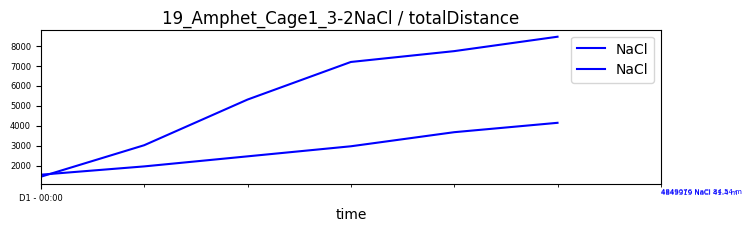

*** ALL JOBS DONE *** 


In [2]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getMinTMaxTInput,getFrameInput


def frameToTimeTicker(x, pos):
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    

if __name__ == '__main__':
    
    print("Code launched.")
    
    #Choose the files to process, and ask for the Start and Enf frames.
    files = getFilesToProcess()
    print("Reminder: 1min = 1800 frames, 1h= 108000 frames, 5h = 540000, 12h = 1296000 frames")
    tmin = getFrameInput("Start")
    tmax = getFrameInput("End")
    
    folderName = input("Enter the name of the new FOLDER in which the images will be saved: ")
    
    #Calculate the timebins of 10minutes:
    nbTimeBins = int((tmax-tmin)/18000) #10min = 18000frames
    timebins = []
    print(f"There will be {nbTimeBins} bins of 10min (18000 frames) in the graph.")
    for i in range(nbTimeBins+1):
        timebins.append(i * 18000)
        
    print(f"The timebinList is: {timebins}")   
    # print(f" with a length of {len(timebins)}. \n")
    
    # behaviorToPlot = input("Which behavior do you want to plot the Cumulated graph? (No choice here... totalDistance) : ")
    behaviorToPlot = "totalDistance"
    
    print("\n This script will plot the totalDistance traveled by the mice in the selected databases... \n")
    
    saveFile = f"figTimeLine-{behaviorToPlot}" # Figure name

    for file in files:
        
        animalTotalDistance = {}
        animalDistancePerBin = {}
        listCumulated = {}
        listValue = {}
        behaviorTimeLine = {}
        
        print(file)
        expName = file[-30:-7] #Select the name of XP in the filename
        #TODO IMPROVE THE NAME OF THE FILE
        print("expName is: ", expName)
        
        connection = sqlite3.connect( file )
    
        pool = AnimalPool( )
        pool.loadAnimals( connection )
        """        
        pool.loadDetection( start = tmin, end = tmax, lightLoad=True)
        """

        for animal in pool.animalDictionnary.keys():
            print( pool.animalDictionnary[animal].RFID )
            
            # Load the timeline of the event over all individuals
            behaviorTimeLine[animal] = EventTimeLine( connection, behaviorToPlot, idA=animal, minFrame=tmin, maxFrame=tmax )
            # behaviorTimeLine[animal].removeEventsBelowLength( maxLen = MIN_WATER_STOP_DURATION )

            print("Computing the distance:")
            pool.animalDictionnary[animal].loadDetection(start=tmin, end=tmax, lightLoad = True)
            animalTotalDistance[animal] = pool.animalDictionnary[animal].getDistance(tmin,tmax)/100 # Total distance in meters (m)
            tenMinBin = 10*30*60 #Bins of 10 minutes = 18000 frames
            print("The time bin is 10min = 18 000 frames.")
            animalDistancePerBin[animal] = pool.animalDictionnary[animal].getDistancePerBin(binFrameSize = tenMinBin , minFrame=tmin, maxFrame=tmax ) # in centimeters (m)
            
            print("\n")
            print(f"The animalDistancePerBin for animal {animal} is:")
            print(animalDistancePerBin[animal])
            print(f"of lenght {len(animalDistancePerBin[animal])}.")
        
        # Build the plot
        fig, ax = plt.subplots(1,1 , figsize=(8, 2 ) )
        ax = plt.gca() # get current axis
        #ax.set_ylim([ymin, ymax])
        
        #set x axis
        ax.set_xlabel("time")
        ax.set_xlim([0, tmax])
        formatter = matplotlib.ticker.FuncFormatter( frameToTimeTicker )
        ax.xaxis.set_major_formatter(formatter)
        ax.tick_params(labelsize=6 )
        ax.xaxis.set_major_locator(ticker.MultipleLocator( 18000 * 12 )) # 10min = 18000 frames
        ax.xaxis.set_minor_locator(ticker.MultipleLocator( 18000 ))
        
        totalDistance = {}
        timeBin = 1
        
        #Print the name and genotype of the animals on the graph, with the corresponding colors and the total distance traveled over the experiment
        maxHeight = max(animalDistancePerBin[1])
        print(f"the maximal Height is: {maxHeight}.")
        legendHeight = int(maxHeight/3) # At one third of the maximal y-value
        rfids_legend = []
        geno_legend = []
        
        for animal in pool.animalDictionnary.keys():
            rfids_legend.append(pool.animalDictionnary[animal].RFID[4:])
            geno_legend.append(pool.animalDictionnary[animal].genotype)

        print("\n")
        print(f"RFID legends: {rfids_legend}")
        print(f"Geno legends: {geno_legend}")
             
        for animal in pool.animalDictionnary.keys():
            # print(f"\n Animal {animal}")
            # listCumulated = []
            # listValue = behaviorTimeLine[animal].getDurationEventInTimeBin( tmin=tmin, tmax=tmax, binSize=timeBin*oneMinute)
            
            listValue[animal] = animalDistancePerBin[animal]
            
            cumul = 0 # To compute the cumulative value of the event (totalDistance here)
            cumulList = []
            for value in listValue[animal]:
                cumul+= value
                # listCumulated[animal].append(cumul)
                cumulList.append(cumul)
                
            totalDistance[animal]= cumulList # totalDistance is a dict with 'animal number' as key and the list of cumulated Distance in values
        
            # print(f"\n Total distance : {totalDistance[animal]} for animal : {animal}.")
        
        print("\n nbtimebins: ", nbTimeBins)
        
        # Check if timebins and totalDistance have the same size :
        # remove one timebin if not.
        while len(timebins) > len(totalDistance[1]):
            timebins.pop()
            print("popped last timebin value")  
            
        for animal in totalDistance:
            if "Amphet" in pool.animalDictionnary[animal].genotype:
                color = "red"  # AMPHET mice in RED
            else:
                color="blue"  # NaCL mice in BLU
            
            totalDistValue = max(totalDistance[animal])
            print(f"\n TotalDistance of animal {animal}: {round(totalDistValue, 2)}")
            
            ax.text(30*60*60, legendHeight, "{} {} {} m".format(pool.animalDictionnary[animal].RFID[5:], 
                                                           pool.animalDictionnary[animal].genotype,
                                                           round(totalDistValue/100,2)), 
                    color = color, fontsize=5)
            
            legendHeight += int(maxHeight/20) 
            
            ax.plot(timebins, totalDistance[animal] , color= color) # color= getAnimalColor( animal )

                
        ax.legend(geno_legend) #ADD THE GENOTYPE AS LEGEND
        fig.suptitle(f"{expName} / {behaviorToPlot}")

        figName = f"FigCumul-{behaviorToPlot}_{expName}.png"
        print (behaviorToPlot)
        print(expName)
        print ("Saving figure... \n" , figName )
        
        os.makedirs(folderName)
        
        fig.savefig(folderName+"/"+figName, dpi=200)
        
        plt.show()
        plt.close( fig )
        
        connection.close() #Stop connection to the DBs
        
    print( "*** ALL JOBS DONE *** ")


In [ ]:
timebins

In [ ]:
behaviorDuration

In [ ]:
len(behaviorDuration[2])

In [ ]:
for i in animalDistancePerBin:
    print(i)